In [1]:
import sys
print(sys.executable)
!{sys.executable} -m pip install pandas

/usr/local/Cellar/jupyterlab/4.2.5/libexec/bin/python

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [7]:
# Package imports
import matplotlib.pyplot as plt
import pandas as pd
import ast
import numpy as np
import sqlite3

In [4]:
# Define local helper functions
import math

def degrees_to_radians(degrees):
    return degrees * (math.pi / 180.0)

def meters_to_yards(meters):
    return meters * 1.09361

def get_distance_between_points_meters(lat1, long1, lat2, long2):
    earth_radius_km = 6371
    deg_lat = degrees_to_radians(lat2 - lat1)
    deg_long = degrees_to_radians(long2 - long1)
    a = math.sin(deg_lat / 2) * math.sin(deg_lat / 2) + math.cos(degrees_to_radians(lat1)) * math.cos(degrees_to_radians(lat2)) * math.sin(deg_long / 2) * math.sin(deg_long / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist_km = earth_radius_km * c
    dist_m = dist_km * 1000
    return dist_m

def get_distance_between_points_yards(lat1, long1, lat2, long2):
    dist_m = get_distance_between_points_meters(lat1, long1, lat2, long2)
    dist_yards = meters_to_yards(dist_m)
    return dist_yards

In [49]:
# More helper functions
def parse_coordinates(coord_str):
    if pd.isnull(coord_str):
        return None  # Return None if the coordinate is null
    return ast.literal_eval(coord_str)

def parse_coordinates_with_parentheses(coord_str):
    if pd.isnull(coord_str):
        return None  # Return None if the coordinate is null
    return ast.literal_eval(coord_str[1:-1])

def distance_from_coords(row):
    if row['start_coordinate'] is None or row['end_coordinate'] is None:
        return 0
    
    return get_distance_between_points_yards(
        row['start_coordinate'][0], row['start_coordinate'][1],
        row['end_coordinate'][0], row['end_coordinate'][1]
    )


# Section 1: Explore Club Statistics

In [24]:
# Import shot data
connection = sqlite3.connect("../data/10-28.sqlite3")
strokes = pd.read_sql_query("SELECT * FROM round_stroke", connection)
connection.close()

display(strokes.describe())
display(strokes.head())

,id,stroke_number,hole_id,rnd_id,penalty
count,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000
mean,1863.422176,2.350551,71.971074,33.548898,0.033747
std,892.297101,1.300101,66.253355,10.783872,0.180638
min,123.000000,1.000000,1.000000,11.000000,0.000000
25%,1037.750000,1.000000,10.000000,27.000000,0.000000
50%,2035.500000,2.000000,60.000000,35.000000,0.000000
75%,2584.250000,3.000000,134.000000,42.000000,0.000000
max,3217.000000,8.000000,216.000000,50.000000,1.000000


,id,club,start_coordinate,end_coordinate,stroke_number,hole_id,rnd_id,penalty
0,123,8,"[39.91568444815508, -86.04792058467865]","[39.91692031566155, -86.04923497275416]",1,14,11,0
1,124,56°,"[39.91692031566155, -86.04923497275416]","[39.91668836719707, -86.04884594678879]",2,14,11,0
2,175,D,"[39.916241359532044, -86.05197742581367]","[39.91607686293417, -86.05331718921661]",1,1,11,0
3,176,7,"[39.91607686293417, -86.05331718921661]","[39.9160820059701, -86.05466902256012]",2,1,11,0
4,177,56°,"[39.9160820059701, -86.05466902256012]","[39.916056547938545, -86.05553671717644]",3,1,11,0


In [121]:
# Clean data
strokes = strokes.dropna()
strokes = strokes[strokes['club'] != 'Club'] # Times where we forgot to input club

# Convert coordinates to tuples
strokes['start_coordinate'] = strokes['start_coordinate'].astype(str).apply(parse_coordinates)
strokes['end_coordinate'] = strokes['end_coordinate'].astype(str).apply(parse_coordinates)

# Add distance column
strokes['distance'] = strokes.apply(distance_from_coords, axis=1)

strokes.describe()

,id,stroke_number,hole_id,rnd_id,penalty,distance
count,1384.000000,1384.000000,1384.000000,1384.000000,1384.0,1384.000000
mean,1866.970376,2.331647,71.331647,33.601879,0.0,115.518694
std,888.209444,1.308732,66.617289,10.718026,0.0,80.275604
min,123.000000,1.000000,1.000000,11.000000,0.0,0.252824
25%,1040.750000,1.000000,10.000000,27.000000,0.0,37.319802
50%,2038.500000,2.000000,58.000000,35.000000,0.0,111.643006
75%,2583.250000,3.000000,134.000000,42.000000,0.0,182.023822
max,3217.000000,8.000000,216.000000,50.000000,0.0,330.066668


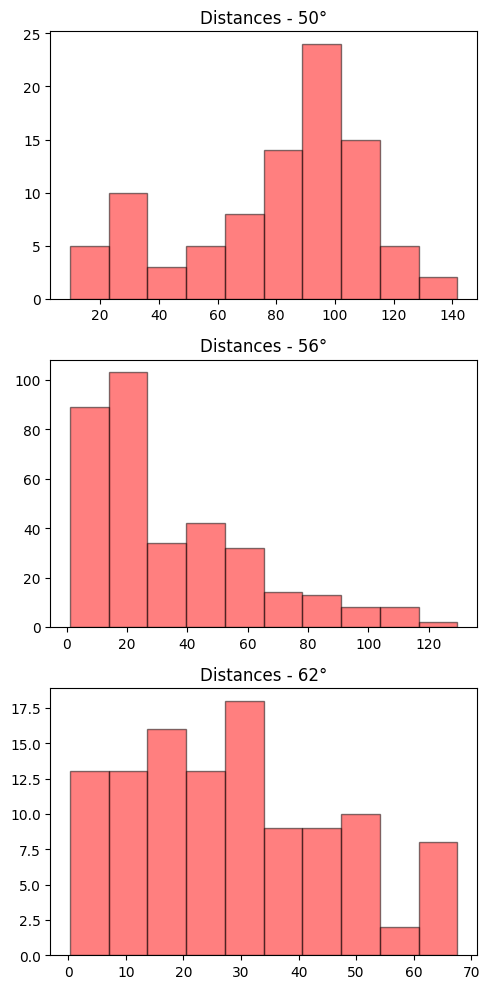

In [122]:
# Plot wedge histograms, descriptions
wedges = ['50°', '56°', '62°']

fig, axs = plt.subplots(3, figsize=(5, 10), tight_layout=True)
for i, wedge in enumerate(wedges):
    strokes_for_wedge = strokes.where(strokes['club'] == wedge)
    axs[i].hist(x = strokes_for_wedge[['distance']], edgecolor='black', color='red', bins=10, alpha=0.5)
    axs[i].set_title(f'Distances - {wedge}')


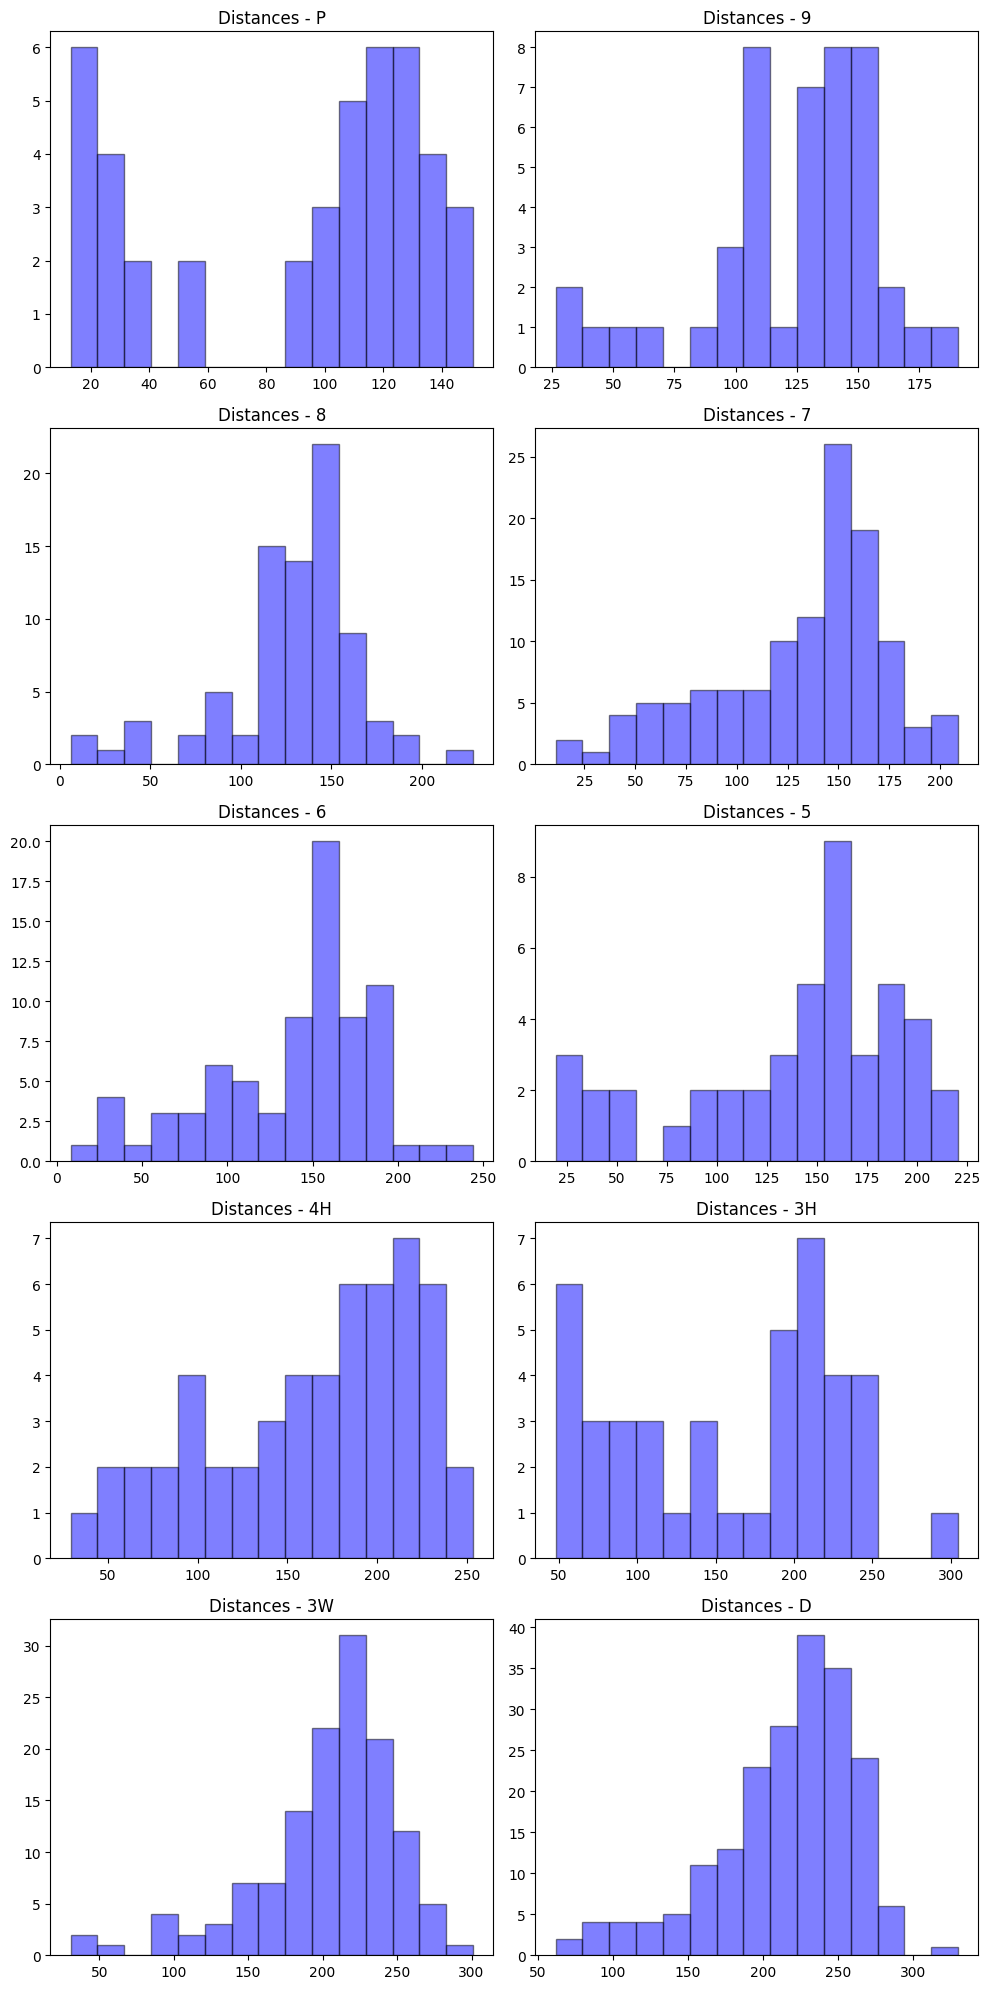

In [123]:
# Plot other club histograms
clubs = ['P', '9', '8', '7', '6', '5', '4H', '3H', '3W', 'D']

fig, axs = plt.subplots(5, 2, figsize=(10, 20), tight_layout=True)
for i, club in enumerate(clubs):
    strokes_for_club = strokes.where(strokes['club'] == club)
    axs[i // 2][i % 2].hist(x = strokes_for_club[['distance']], edgecolor='black', color='blue', bins=15, alpha=0.5)
    axs[i // 2][i % 2].set_title(f'Distances - {club}')

In [152]:
stroke_descriptions = strokes.groupby(['club'])['distance'].describe().sort_values(by='mean')
display(stroke_descriptions)

,count,mean,std,min,25%,50%,75%,max
club,,,,,,,,
62°,111.0,28.836957,17.906451,0.252824,14.428515,27.386890,41.940557,67.566983
56°,345.0,33.683610,26.813236,1.031457,13.736774,23.906938,49.134610,129.490469
50°,91.0,80.203147,30.808744,9.703287,63.311521,90.596142,101.022585,141.619374
P,43.0,90.582169,47.309305,13.035304,32.813676,111.932803,127.273635,150.686426
9,45.0,123.093823,36.340463,26.404489,108.110195,134.700298,147.682885,190.887843
8,81.0,128.676293,38.592016,6.045629,116.169536,133.631695,150.141220,228.232278
7,119.0,131.742337,42.033196,10.805023,106.744456,143.947613,159.812184,208.805957
5,45.0,137.923620,54.453733,19.428896,106.075160,156.123877,176.239725,220.560562
6,78.0,138.862773,48.834321,8.081561,105.394305,153.584995,169.582579,243.894000


Text(0.5, 1.0, 'Club Distance - Maximums')

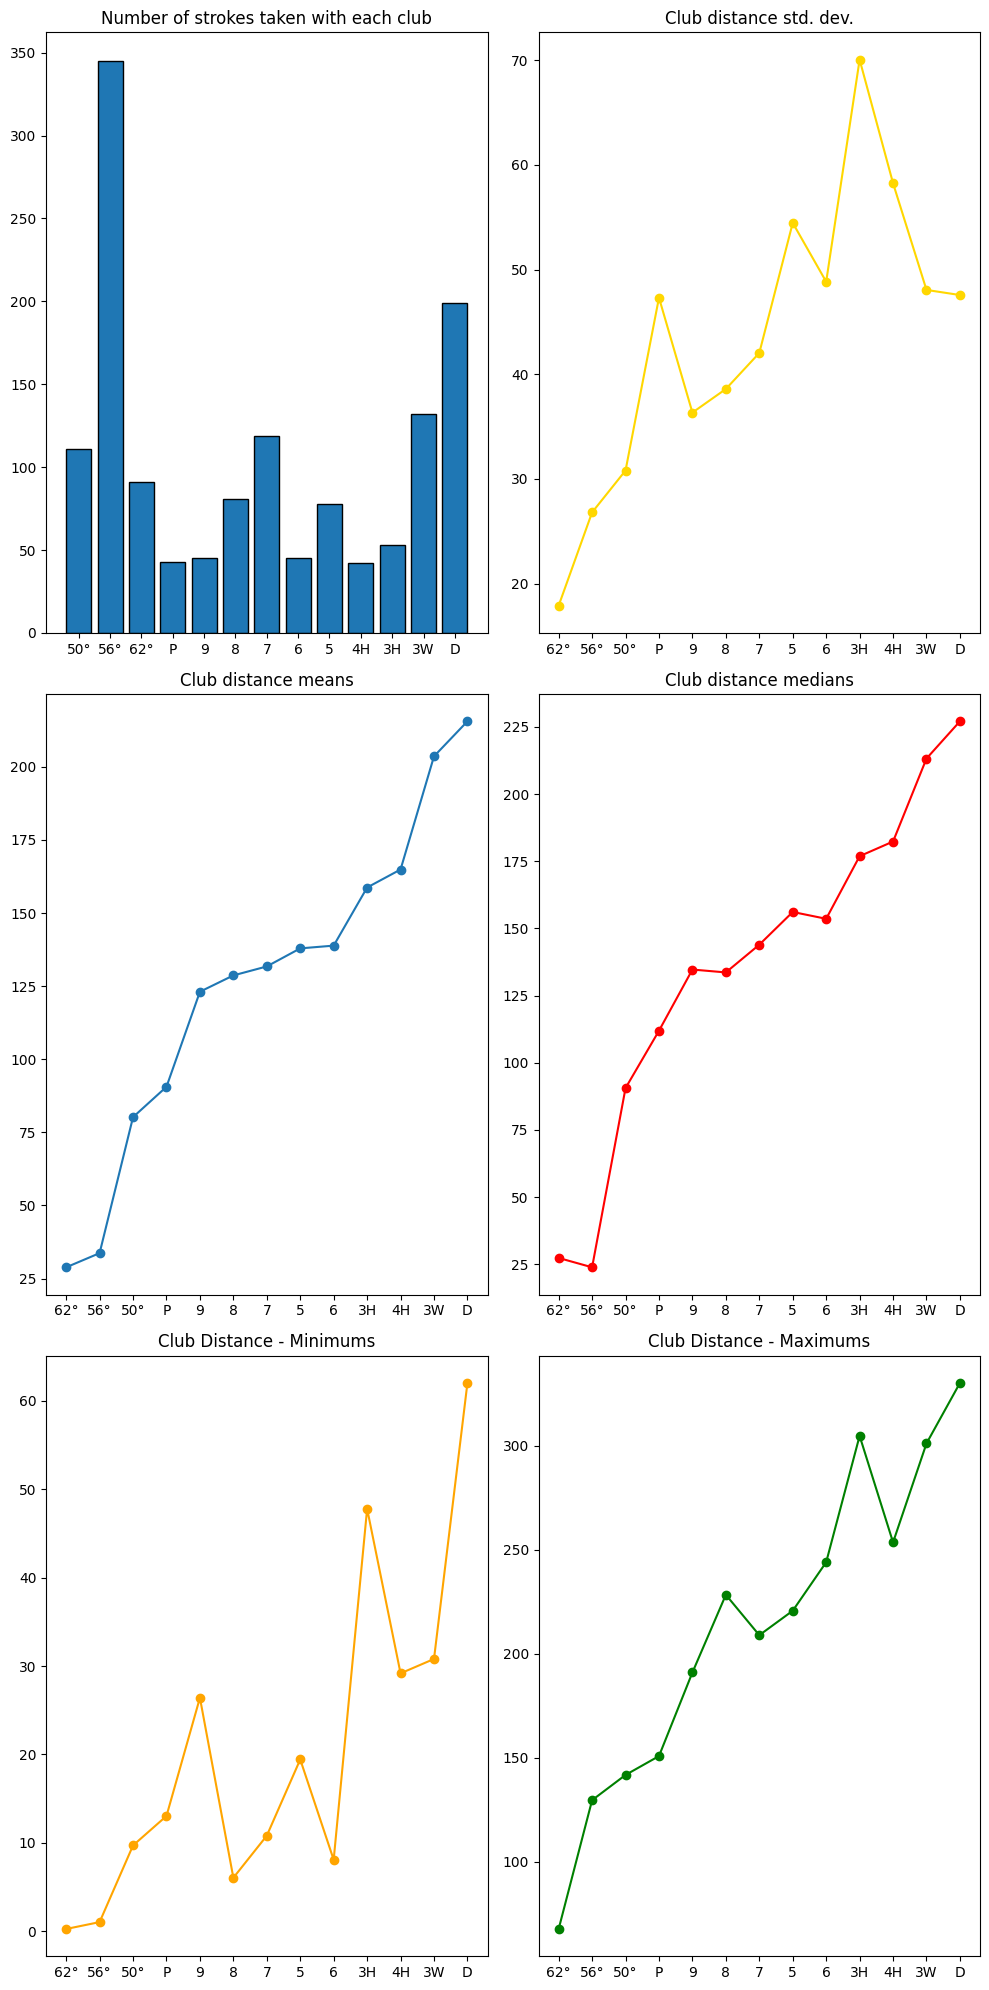

In [162]:
all_clubs = wedges + clubs
fig, axes = plt.subplots(3, 2, figsize=(10, 20), tight_layout=True)

# Number of Shots taken with each club
axes[0][0].bar(all_clubs, stroke_descriptions['count'], edgecolor='black')
axes[0][0].set_title('Number of strokes taken with each club')

axes[0][1].plot(stroke_descriptions['std'], marker='o', color='gold')
axes[0][1].set_title('Club distance std. dev.')

axes[1][0].plot(stroke_descriptions['mean'], marker='o')
axes[1][0].set_title('Club distance means')

axes[1][1].plot(stroke_descriptions['50%'], marker='o', color='red')
axes[1][1].set_title('Club distance medians')

# Mins/maxes
axes[2][0].plot(stroke_descriptions['min'], marker='o', color='orange')
axes[2][0].set_title('Club Distance - Minimums')
axes[2][1].plot(stroke_descriptions['max'], marker='o', color='green')
axes[2][1].set_title('Club Distance - Maximums')